## Typical LISA experiment

This notebook shows a typical LISA-use case:

* Connecting to a target
* Configuring an rt-app workload
* Collecting a trace while executing a workload
* Displaying the trace
* Analysing the trace

It can serve as a template for different kind of experiments, - you could only change the workload to execute & the trace events to collect

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2025-02-05 13:09:45,223 INFO    : root         : Using LISA logging configuration: /home/dourai01/Work/projects/lisa/logging.conf


## Target configuration

Target communication is abstracted away under a **Target** class. We're going to create an instance of it and that'll let us run whatever experiment we want on a given target.

Relevant documentation:

* **Target**: https://tooling.sites.arm.com/lisa/latest/target.html#lisa.target.Target
* **TargetConf**: https://tooling.sites.arm.com/lisa/latest/sections/api/generated/lisa.target.TargetConf.html

In [2]:
from lisa.target import Target, TargetConf

In [3]:
# target = Target(
#     kind='linux',
#     name='myhikey960',
#     host='192.168.0.1',
#     username='root',
#     password='root',
# )
# Uses settings from target_conf.yml
target = Target.from_default_conf()

2025-02-05 13:09:52,578 WARNING : lisa.target.Target : No platform information could be found: Key "('platform-info',)" needs to appear at the top level
2025-02-05 13:09:52,582 INFO    : lisa.target.Target : Target configuration:
├ devlib:
    ├ excluded-modules from default (list): []
    ├ max-async from user (int): 5
    └ platform:
        └ class from default (str): devlib.platform.Platform
├ host from user (str): 127.0.0.1
├ kernel:
    ├ modules:
        ├ build-env from user (str): host
        ├ make-variables from user (dict): {'V': 1}
        └ overlay-backend from user (str): overlayfs
    └ src from user (str): /home/dourai01/Work/projects/linux-master
├ kind from user (str): linux
├ lazy-platinfo from user (bool): True
├ name from default (str): <noname>
├ password from user (str): <password>
├ port from user (int): 8022
├ strict-host-check from user (bool): True
├ tools from default (list): []
├ username from user (str): root
└ wait-boot:
    ├ enable from default (bool)

## Setting up an rt-app workload

rt-app is very convenient for scheduler experiments, and the majority of the tests within LISA rely on it. Here we're going to create a somewhat useless workload just to show off the API.

Relevant documentation:

* **rt-app**: https://github.com/scheduler-tools/rt-app
* **rt-app LISA class**: https://tooling.sites.arm.com/lisa/latest/sections/api/generated/lisa.wlgen.rta.RTA.html
* **RTAPhase class**: https://tooling.sites.arm.com/lisa/latest/sections/api/generated/lisa.wlgen.rta.RTAPhase.html
* **PeriodicWload class**: https://tooling.sites.arm.com/lisa/latest/sections/api/generated/lisa.wlgen.rta.PeriodicWload.html


In [4]:
from lisa.wlgen.rta import RTA, RTAPhase, PeriodicWload

In [5]:
rtapp_profile = {
    f'tsk{cpu}_{i}': RTAPhase(
        prop_wload=PeriodicWload(
            duty_cycle_pct=20,
            period=16e-3,
            duration=1,
        )
    )
    for cpu in range(target.number_of_cpus)
    for i in range(3)
}

rt-app needs some calibration information (20% duty cycle isn't the same amount of work on all platforms!). It can be manually specified like so:

In [6]:
def provide_calibration(calibration):
    target.plat_info["rtapp"].add_src("user", {"calib" : calibration})

In [9]:
# Uncomment if you want to use this
# provide_calibration({0: 307, 1: 302, 2: 302, 3: 302, 4: 155, 5: 155, 6: 155, 7: 155})

However, it is automatically collected when first creating an rt-app workload if it is not specified, so you can forego the above step and let the calibration happen on-demand:

In [10]:
wload = RTA.from_profile(target, rtapp_profile, name='experiment_workload')

2025-02-05 13:10:44,572 INFO    : lisa.target.Target : Creating result directory: /home/dourai01/Work/projects/lisa/results/Target-<noname>-20250205_131044.570241
2025-02-05 13:10:44,578 INFO    : lisa.target.Target : Creating result directory: /home/dourai01/Work/projects/lisa/results/Target-<noname>-20250205_131044.578229
2025-02-05 13:10:44,582 INFO    : lisa.target.Target : Creating result directory: /home/dourai01/Work/projects/lisa/results/Target-<noname>-20250205_131044.582048
2025-02-05 13:10:44,586 INFO    : lisa.target.Target : Creating result directory: /home/dourai01/Work/projects/lisa/results/Target-<noname>-20250205_131044.582048/RTA-experiment_workload-20250205_131044.586347


## Running the workload

In [11]:
import os
from lisa.trace import FtraceCollector

We need to specify the trace events we want to record. We could list what's available like so:

In [12]:
available_events = target.execute("cat /sys/kernel/debug/tracing/available_events").splitlines()

# That's gonna be a pretty big list, let's focus on the scheduler events
sched_events = [
    event
    for event in available_events
    if (
        event.startswith("sched:") or
        event.startswith("task:")
    )
]
print(sched_events)

['task:task_newtask', 'task:task_rename', 'sched:sched_kthread_stop', 'sched:sched_kthread_stop_ret', 'sched:sched_kthread_work_queue_work', 'sched:sched_kthread_work_execute_start', 'sched:sched_kthread_work_execute_end', 'sched:sched_waking', 'sched:sched_wakeup', 'sched:sched_wakeup_new', 'sched:sched_switch', 'sched:sched_migrate_task', 'sched:sched_process_free', 'sched:sched_process_exit', 'sched:sched_wait_task', 'sched:sched_process_wait', 'sched:sched_process_fork', 'sched:sched_process_exec', 'sched:sched_prepare_exec', 'sched:sched_stat_wait', 'sched:sched_stat_sleep', 'sched:sched_stat_iowait', 'sched:sched_stat_blocked', 'sched:sched_stat_runtime', 'sched:sched_pi_setprio', 'sched:sched_move_numa', 'sched:sched_stick_numa', 'sched:sched_swap_numa', 'sched:sched_skip_vma_numa', 'sched:sched_wake_idle_without_ipi']


Let's just collect the base events required to plot task scheduling:

In [13]:
events = [
    'sched_switch',
    'sched_wakeup',
    'sched_wakeup_new',
    'task_rename',
]

And now we can actually record traces while running our workload:

In [14]:
trace_path = os.path.join(wload.res_dir, "trace.dat")
ftrace_coll = FtraceCollector(target, events=events, buffer_size=10240, output_path=trace_path)

with wload, ftrace_coll:
    wload.run()

2025-02-05 13:11:01,183 INFO    : lisa._kmod._KernelBuildEnv : Toolchain detected: CC=clang, CROSS_COMPILE=aarch64-linux-gnu-, LLVM=1, ARCH=arm64
2025-02-05 13:11:01,375 INFO    : lisa._kmod._KernelBuildEnv : Toolchain detected: CC=clang, CROSS_COMPILE=aarch64-linux-gnu-, LLVM=1, ARCH=arm64
2025-02-05 13:11:15,765 INFO    : sched        : Scheduler sched_domain procfs entries found
2025-02-05 13:11:15,766 INFO    : sched        : Detected kernel compiled with SCHED_DEBUG=y
2025-02-05 13:11:15,767 INFO    : sched        : CPU capacity sysfs entries found
2025-02-05 13:11:20,433 INFO    : lisa.wlgen.rta.RTA : Created workload's run target directory: /root/devlib-target/lisa/wlgen/20250205_131044_3b90c73fb83a4959bb7f2bb0d65dff75
2025-02-05 13:11:22,861 WARNING : lisa.wlgen.rta.RTA : CPU capacities will not be updated on this platform
2025-02-05 13:11:22,864 INFO    : lisa.wlgen.rta.RTA : CPU capacities according to rt-app workload: {0: 1024, 1: 1024, 2: 1024, 3: 1024}
2025-02-05 13:11:46,

## Loading up the trace

We have a Trace class that lets us easily access trace events. It can also do some post-processing to provide different kinds of analysis.

In [15]:
from lisa.trace import Trace

We also save some platform information (number of CPUs, available frequencies, kernel version...) that comes in handy for doing some analysis:

In [16]:
print(target.plat_info)

├ abi from target (str): arm64
├ cpu-capacities:
    ├ orig from target (dict): {0: 1024, 1: 1024, 2: 1024, 3: 1024}
    ├ writeable from target (bool): False
    └ rtapp from user(platform-info/rtapp/calib),target(platform-info/cpu-capacities/orig),target(platform-info/cpu-capacities/writeable) (dict): {0: 1024, 1: 1024, 2: 1024, 3: 1024}
├ cpus-count from target (int): 4
├ freq-domains from target (FilteredDeferredValue): <lazy value of freq-domains>
├ freqs from target (FilteredDeferredValue): <lazy value of freqs>
├ kernel:
    ├ config from target (TypedKernelConfig): <kernel config>
    ├ symbols-address from target (FilteredDeferredValue): <symbols address>
    └ version from target (KernelVersion): 6.13.0-00918-g95ec54a420b8 6 SMP PREEMPT Fri Jan 24 22:39:48 GMT 2025
├ name from target-conf (str): <noname>
├ nrg-model from target (FilteredDeferredValue): <lazy value of nrg-model>
├ numa-nodes-count from target (int): 1
├ os from target (FilteredDeferredValue): <lazy value of os

You can pass the platform info directly from the **Target**, but it's a good idea to save it on the disk so that you can re-run whatever analysis code you want several months down the line after the platform was lost in a tragic fire.
It's why we save this information somewhere instead of polling the target when we want to use them - we can run analysis code offline.
Here we show how to save to/restore this platform information from the disk.

In [17]:
plat_info_path = os.path.join(wload.res_dir, "platinfo.yaml")
target.plat_info.to_yaml_map(plat_info_path)

2025-02-05 13:12:24,094 INFO    : lisa.energy_model.EnergyModel.from_target : Attempting to load EM using LinuxEnergyModel
2025-02-05 13:12:25,551 ERROR   : LinuxTarget  : Module "cpufreq" failed to install on target: Module "cpufreq" is not supported by the target
2025-02-05 13:12:25,554 INFO    : lisa.target.Target : Loading target devlib module cpufreq
2025-02-05 13:12:25,993 ERROR   : LinuxTarget  : Module "cpufreq" failed to install on target: Module "cpufreq" is not supported by the target
2025-02-05 13:12:26,540 ERROR   : LinuxTarget  : Module "cpufreq" failed to install on target: Module "cpufreq" is not supported by the target
2025-02-05 13:12:26,543 INFO    : lisa.target.Target : Loading target devlib module cpufreq
2025-02-05 13:12:27,073 ERROR   : LinuxTarget  : Module "cpufreq" failed to install on target: Module "cpufreq" is not supported by the target
2025-02-05 13:12:27,093 INFO    : lisa.platforms.platinfo.PlatformInfo : Attempting to read kallsyms from target


In [18]:
from lisa.platforms.platinfo import PlatformInfo

In [19]:
plat_info = PlatformInfo.from_yaml_map(plat_info_path)

trace_path = os.path.join(wload.res_dir, 'trace.dat')
trace = Trace(trace_path, plat_info=plat_info)

## Looking at the trace

Kernelshark can be opened from the notebook:

In [20]:
# trace.show()

## Analysing the trace

Relevant documentation: https://tooling.sites.arm.com/lisa/latest/trace_analysis.html

### DataFrame libraries

LISA supports two dataframe (table) libraries:
* polars: https://docs.pola.rs/api/python/stable/reference/index.html
* pandas: https://pandas.pydata.org/docs/index.html

Polars is a more modern alternative to pandas and most of the internal machinery of LISA has been moved to polars. At this point, pandas is available for backward compatibility and some internal code still has not been converted, but eventually there will not be any direct dependencies on pandas anymore.
Since most dataframe-producing APIs are related to the Trace class, the switch between the two libraries can be achieved at that level:

In [21]:
import polars as pl

# This creates a view of the trace that will provide polars.LazyFrame dataframes.
# It is also possible to create the trace object for polars directly with
# Trace(..., df_fmt='polars-lazyframe'). The result is the same.
trace = trace.get_view(df_fmt='polars-lazyframe')

By default, Trace will use the timestamps collected in the trace. While useful to correlate to other system's aspects (e.g. dmesg log), this is ideal when comparing multiple runs of the same workload, or even a single run if the absolute timestamp does not matter.

In [22]:
# This can be achieved in Trace directly with Trace(..., normalize_time=True)
trace = trace.get_view(normalize_time=True)

### Reading trace events

In [23]:
df = trace.df_event("sched_switch")
df.collect()

Time,__cpu,__pid,prev_comm,prev_pid,prev_prio,prev_state,next_comm,next_pid,next_prio,__comm
duration[ns],u32,i32,cat,i32,i32,i64,cat,i32,i32,cat
207936ns,0,0,"""swapper/0""",0,120,0,"""sshd""",4850,120,"""<idle>"""
500784ns,3,4986,"""trace-cmd""",4986,120,32,"""swapper/3""",0,120,null
3699136ns,2,0,"""swapper/2""",0,120,0,"""rcu_preempt""",16,120,"""<idle>"""
3783872ns,0,4850,"""sshd""",4850,120,0,"""migration/0""",19,0,"""sshd"""
4034304ns,2,16,"""rcu_preempt""",16,120,128,"""swapper/2""",0,120,"""rcu_preempt"""
…,…,…,…,…,…,…,…,…,…,…
4s 417871968ns,0,4059,"""kworker/u16:4""",4059,120,128,"""swapper/0""",0,120,"""kworker/u16:4"""
4s 424197680ns,1,0,"""swapper/1""",0,120,0,"""rcu_preempt""",16,120,"""<idle>"""
4s 424765088ns,1,16,"""rcu_preempt""",16,120,128,"""swapper/1""",0,120,"""rcu_preempt"""


In [24]:
task = df.filter(
    pl.col('__comm')
        # All string fields in ftrace events are loaded as Categorical in LISA due to their repetitive nature.
        .cast(pl.String)
        .str.starts_with("tsk")
).select(pl.col('__comm').first()).collect().item()
task

'tsk0_0-0'

The standard DataFrame operations are available, so you can filter/slice it however you wish:

In [26]:
df.filter(pl.col('next_comm') == task).collect()

Time,__cpu,__pid,prev_comm,prev_pid,prev_prio,prev_state,next_comm,next_pid,next_prio,__comm
duration[ns],u32,i32,cat,i32,i32,i64,cat,i32,i32,cat
1s 330732µs,0,4999,"""tsk3_0-9""",4999,120,1,"""tsk0_0-0""",4990,120,"""tsk3_0-9"""
1s 387599856ns,0,4996,"""tsk2_0-6""",4996,120,0,"""tsk0_0-0""",4990,120,"""tsk2_0-6"""
1s 411637296ns,0,4999,"""tsk3_0-9""",4999,120,0,"""tsk0_0-0""",4990,120,"""tsk3_0-9"""
1s 427541936ns,0,4992,"""tsk0_2-2""",4992,120,0,"""tsk0_0-0""",4990,120,"""tsk0_2-2"""
1s 443112992ns,0,4999,"""tsk3_0-9""",4999,120,0,"""tsk0_0-0""",4990,120,"""tsk3_0-9"""
…,…,…,…,…,…,…,…,…,…,…
2s 428980128ns,0,4868,"""sshd""",4868,120,1,"""tsk0_0-0""",4990,120,"""sshd"""
2s 435000064ns,0,4997,"""tsk2_1-7""",4997,120,0,"""tsk0_0-0""",4990,120,"""tsk2_1-7"""
2s 443807664ns,0,0,"""swapper/0""",0,120,0,"""tsk0_0-0""",4990,120,"""<idle>"""


### Using the trace analysis

#### Example dataframes

LISA ships a number of namespaced trace analysis methods. They can all be called on a trace with `trace.ana.<analysis name>.<method name>()`.
They fall mostly into two categories:
 * Method starting with `df_`: returns a pandas DataFrame
 * Method starting with `plot_`: returns a holoviews element ready to be displayed

In [27]:
trace.ana.tasks.df_tasks_runtime().collect()

pid,comm,runtime
i32,cat,f64
5002,"""sh""",0.109627
4990,"""tsk0_0-0""",0.331726
4868,"""sshd""",0.344764
27,"""migration/2""",0.026698
5005,"""trace-cmd""",0.351035
…,…,…
4998,"""tsk2_2-8""",0.27628
4870,"""sshd""",0.288097
4995,"""tsk1_2-5""",0.331213


In [28]:
df = trace.ana.tasks.df_task_states(task, stringify=True)
df.collect()

Time,target_cpu,cpu,curr_state,next_state,delta,duration_delta,curr_state_str,next_state_str
duration[ns],i32,u32,i64,i64,f64,duration[ns],str,str
1s 240709136ns,-1,0,1,512,0.0883236,88323600ns,"""S""","""R"""
1s 329032736ns,0,3,512,8192,0.001699,1699264ns,"""R""","""R"""
1s 330732µs,-1,0,8192,1,0.001847,1847488ns,"""R""","""S"""
1s 332579488ns,-1,0,1,512,0.048222,48222496ns,"""S""","""R"""
1s 380801984ns,0,0,512,8192,0.006798,6797872ns,"""R""","""R"""
…,…,…,…,…,…,…,…,…
2s 447198400ns,-1,0,8192,1,0.00662,6619728ns,"""R""","""S"""
2s 453818128ns,-1,0,1,512,0.006069,6068768ns,"""S""","""R"""
2s 459886896ns,0,0,512,8192,0.000101,100928ns,"""R""","""R"""


The `trace.ana` object can be used to set default values to analysis methods. Simply calling it with keyword arguments will set default values, which can later be overridden when the method is called if necessary. 

This avoids repetition of fixed parameters such as `ŧask`, `tasks`, `cpu` etc. Just be careful as some methods might take more parameters than you expect: some task-related methods also accept a `cpu` parameter to restrict to a given CPU, so it might be a good idea to have a proxy object for all CPU-related calls and another one for task-related calls.

In [30]:
ana = trace.ana(task=task)

df = ana.tasks.df_task_states(stringify=True)

# Default values can be overridden by calling it again
ana2 = ana(task='trace-cmd')
# And overridden again when calling the method
df = ana2.tasks.df_task_states(task=task, stringify=True)

In [31]:
from lisa.analysis.tasks import TaskState

In [32]:
# df[df.curr_state == TaskState.TASK_ACTIVE][1:1.2]

df.filter(pl.col('curr_state') == TaskState.TASK_ACTIVE).collect()

Time,target_cpu,cpu,curr_state,next_state,delta,duration_delta,curr_state_str,next_state_str
duration[ns],i32,u32,i64,i64,f64,duration[ns],str,str
1s 330732µs,-1,0,8192,1,0.001847,1847488ns,"""R""","""S"""
1s 387599856ns,-1,0,8192,0,0.004855,4854832ns,"""R""","""R"""
1s 411637296ns,-1,0,8192,0,0.004184,4184384ns,"""R""","""R"""
1s 427541936ns,-1,0,8192,0,0.004365,4364944ns,"""R""","""R"""
1s 443112992ns,-1,0,8192,0,0.004048,4048112ns,"""R""","""R"""
…,…,…,…,…,…,…,…,…
2s 428980128ns,-1,0,8192,0,0.001849,1848960ns,"""R""","""R"""
2s 435000064ns,-1,0,8192,1,0.001505,1504816ns,"""R""","""S"""
2s 443807664ns,-1,0,8192,0,0.003066,3066496ns,"""R""","""R"""


#### Example plots

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
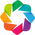

In [33]:
import holoviews as hv
# Before rendering any plot, a plotting backend for holoviews has to be chosen.
# Bokeh provides much better interactive (and HTML) plots than matplotlib.

# THIS MUST BE DONE AFTER ALL IMPORTS.
# Otherwise there might be issues that lead to
# not displaying plots until hv.extension() is called again.

hv.extension('bokeh')

In [38]:
trace.ana.tasks.plot_task_total_residency(task)

:Bars   [cpu]   (runtime)

In [36]:
trace.ana.tasks.plot_tasks_wakeups_heatmap(bins=200)

:HeatMap   [Time,CPU]   (sched_wakeup)

In [37]:
trace.ana.tasks.plot_tasks_forks_heatmap(bins=200)

:HeatMap   [Time,CPU]   (sched_wakeup_new)